#Convolutional Neural Network with color images




In [1]:
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


## 1. CIFAR10 Dataset


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

https://www.cs.toronto.edu/~kriz/cifar.html



### 1.1 Load dataset from tensorflow library

When we load the dataset below, X_train and X_test will contain the images, and y_train and y_test will contain the digits that those images represent.

The label data is ranging from 0 to 9, which corresponds to each of the 10 classes in CIFAR-10.

*   airplane : 0
*   automobile : 1
*   bird : 2
*   cat : 3
*   deer : 4
*   dog : 5
*   frog : 6
*   horse : 7
*   ship : 8
*   truck : 9


In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


170500096/170498071 [==============================] - 18s 0us/step


In [3]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (50000, 32, 32, 3)
y_train (50000, 1)
X_test (10000, 32, 32, 3)
y_test (10000, 1)


In [0]:
def label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### 1.2 Pre-process the data


we need to reshape our dataset inputs (X_train and X_test) to the shape that Keras/Tensorflow model expects when we train the model. The first number is the number of images (55,000 for X_train and 10,000 for X_test). Then comes the shape of each image (28x28). The last number is 1, which signifies that the images are greyscale.

We also need to ‘one-hot-encode’ the target variable y_train and y_test. This means that a column will be created for each output category and a binary variable is inputted for each category. For example, 
*   6 should be encoded to [0, 0, 0, 0, 0, 1, 0, 0, 0, 0 ]
*   1 should be encoded to [0, 1, 0, 0, 0, 0, 0, 0, 0, 0 ]
*   0 should be encoded to [1, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]
*   and so on.

We use Keras to_categorical function to do this one-hot-encode.



In [0]:
#X_train = X_train.astype(np.float32).reshape(X_train.shape[0], height, width, channels)
#X_test = X_test.astype(np.float32).reshape(X_test.shape[0], height, width, channels)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_train /= 255
X_test /= 255

input_shape = X_train.shape[1:]


from keras.utils import to_categorical
#one-hot-encode’ for target variable y_train and y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [6]:
print("input_shape", input_shape)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


input_shape (32, 32, 3)
X_train (50000, 32, 32, 3)
y_train (50000, 10)
X_test (10000, 32, 32, 3)
y_test (10000, 10)


### 1.2 Visulize the CIFAR-10 data

Show randomly 100 images from the dataset.

In [0]:
def plot_random_100_images(data, label, prediction = None, prediction_provided = False):

    _, img_height, img_width, img_channels = data.shape
    _, axarr = plt.subplots(10,10,figsize=(12,12))
    plt.subplots_adjust(wspace=0.8, hspace=2)

    for i in range(10):
        for j in range(10):
           index = np.random.randint(data.shape[0])
           groundtruth_lable = label_names()[np.argmax(label[index])]
           if prediction_provided == True:
              predicted_lable = label_names()[np.argmax(prediction[index])]

           axarr[i,j].imshow(data[index].reshape((img_height, img_width, img_channels), order = 'F'), cmap="binary", interpolation="nearest")          
           axarr[i,j].axis('off')  
           axarr[i,j].set_title(groundtruth_lable)
           #axarr[i,j].text(0.5, 0.5, groundtruth_lable,bbox=dict(facecolor='lightgreen', alpha=0.5))
          
           if prediction_provided == True:
              axarr[i,j].text(-5, 45, predicted_lable,bbox=dict(facecolor='pink', alpha=0.5))


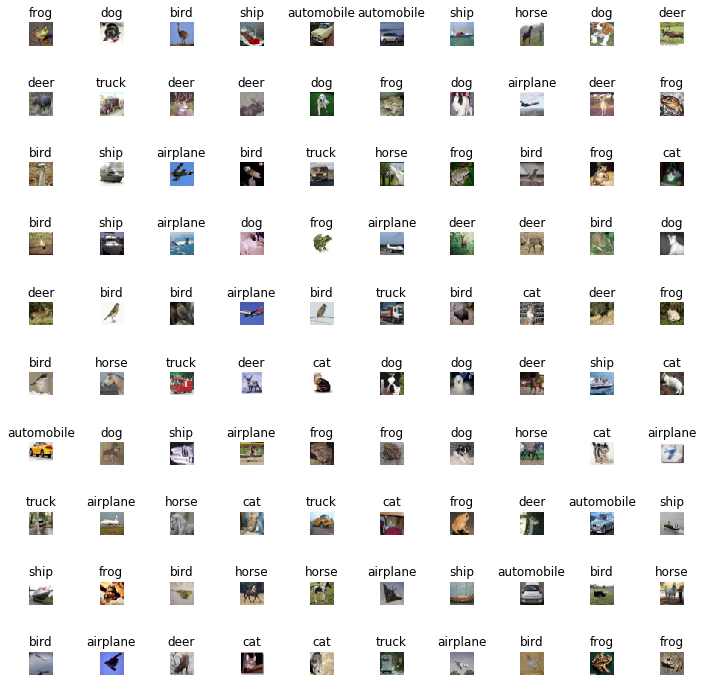

In [8]:
plot_random_100_images(X_train, y_train)

## 2. Build the CNN


First, setup some parameters.

In [0]:
_, height, width, channels = X_train.shape
n_inputs = height * width
num_classes = 10
batch_size = 128
epochs = 50

Below are brief description of each layer of the CNN model.

### Conv2d
The first 2 layers are Conv2D layers. These are convolution layers that will deal with the input images, which are seen as 2-dimensional matrices.

> ***First Layer:  Conv2D(64, (3, 3), input_shape = (28, 28, 1), activation = 'relu')***

>***Second Layer: Conv2D(32, (3, 3), activation = 'relu') ***

1.   The first parameter is the number of nodes which is 64 in the first layer and 32 in the second layer. This number can be adjusted to be higher or lower, depending on the size of the dataset. In our case, 64 and 32 work well, so we will stick with this for now.
2.   The second parameter is the filter size, we use 3 x 3 filter here.
3.   The third parameter is the input shape. This is the shape of each input image, which is 28,28,1 for MNIST dataset for the greyscale images.
3.   The last parameter is activation function for the layer. The activation function we will be using for our first 2 layers is the ReLU. This activation function has been proven to work well in neural networks.
4.   We do not need to specify input_shape for the second layer.

### Max Pooling

> ***MaxPooling2D(pool_size = (2, 2))***

1.    We add MaxPooling for both first and second Layer
2.    The pool size is (2, 2)


### Flattening

1.    Next layer is the ‘Flatten’ layer. Flatten serves as a connection between the convolution and dense layers.

### Dense

1.    Dense is a standard layer type that is used in many cases for neural networks.
2.    We have two Dense layers, the first has 128 units, using "relu" as activation.
3.    The second Dense layer is the output layer, it has 10 units reflecting the 10 classes, it is using "softmap" as activation.


### Dropout

1.    We use two Dropout layer in between to reduce the overfitting.


In [10]:
# Initialising the CNN
cnn_model = Sequential()

# 1 - First Convolution and Pooling layer
cnn_model.add(Conv2D(128, kernel_size=(3, 3), input_shape = input_shape, activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))


# 2 - Second Convolution and Pooling layer
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.25))


#cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu'))
#cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
#cnn_model.add(Dropout(0.25))


# 3 - Flattening
cnn_model.add(Flatten())

# 4 - Full connection
cnn_model.add(Dense(units = 256, activation = 'relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(units = num_classes, activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Compiling the model

Next, we need to compile our model. Compiling the model takes three parameters: **optimizer**, **loss** and **metrics**.

The **optimizer** controls the learning rate. We will be using ‘adam’ as our optmizer. Adam is generally a good optimizer to use for many cases. The adam optimizer adjusts the learning rate throughout training.

The **loss** function is  ‘categorical_crossentropy’ for our model. This is the most common choice for classification. A lower score indicates that the model is performing better.

The **metrics** we are using is "accuracy", it is to make things easier to interpret, we will be able to see the accuracy score on the validation set when we train the model.

In [0]:
# 5 - Compiling the CNN
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Fit the model

Now we will train our model with training data (train_X), target data (train_y), validation data, and the number of epochs.

For our validation data, we will use the test set provided to us in our dataset, which we have split into X_test and y_test.

The number of epochs is the number of times the model will cycle through the data. The more epochs we run, the more the model will improve, up to a certain point. After that point, the model will stop improving during each epoch. 

The training will take some time depends on the amount of data and epoch, the function provide verbose parameter that can display the progress of the training, 
*   verbose=0 will show you nothing (silent)
*   verbose=1 will show you an animated progress bar like this: [================================= ]
*   verbose=2 will just show the number of epoch like this: Epoch 2/3


In [12]:
cnn_model.fit(X_train, y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))



Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 277s 6ms/step - loss: 1.6348 - acc: 0.4010 - val_loss: 1.3304 - val_acc: 0.5248
Epoch 2/50
50000/50000 [==============================] - 274s 5ms/step - loss: 1.3075 - acc: 0.5342 - val_loss: 1.1217 - val_acc: 0.6109
Epoch 3/50
50000/50000 [==============================] - 278s 6ms/step - loss: 1.1706 - acc: 0.5862 - val_loss: 1.1364 - val_acc: 0.6023
Epoch 4/50
50000/50000 [==============================] - 283s 6ms/step - loss: 1.0970 - acc: 0.6145 - val_loss: 1.0497 - val_acc: 0.6359
Epoch 5/50
50000/50000 [==============================] - 276s 6ms/step - loss: 1.0288 - acc: 0.6390 - val_loss: 0.9440 - val_acc: 0.6705
Epoch 6/50
50000/50000 [==============================] - 284s 6ms/step - loss: 0.9773 - acc: 0.6601 - val_loss: 0.8766 - val_acc: 0.6994
Epoch 7/50
50000/50000 [==============================] - 275s 5ms/step - 

In [13]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 12s 1ms/step
Test loss: 0.7290537383079528
Test accuracy: 0.7621


In [17]:
score = cnn_model.evaluate(X_train, y_train, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

50000/50000 [==============================] - 56s 1ms/step
Train loss: 0.22738456468343735
Train accuracy: 0.94964


## 3. Make predictions

We can use the trained model to make predictions, we will send X_test data to make predictions. 

The predict function will give an array with 10 numbers in each row. These numbers are the probabilities that the input image represents each digit (0–9). The array index with the highest number represents the model prediction. The sum of each array equals 1 (since each number is a probability).

Each array item in the output of predict function looks like: [0.000013, 0.00025, 0.996923, 0.0002, 0.0001, 0.0003 ....], then this value can be seen as [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0].

We can then use np.argmax(predicted[index]) to retrive its value as 2. 



In [14]:
y_test_predicted = cnn_model.predict(X_test,
                                     batch_size=batch_size,
                                     verbose=1)

10000/10000 [==============================] - 11s 1ms/step


## Visualize the predicted data

We will plot the random images from the predicted images to visualize the predicted data, together with ground truth label.

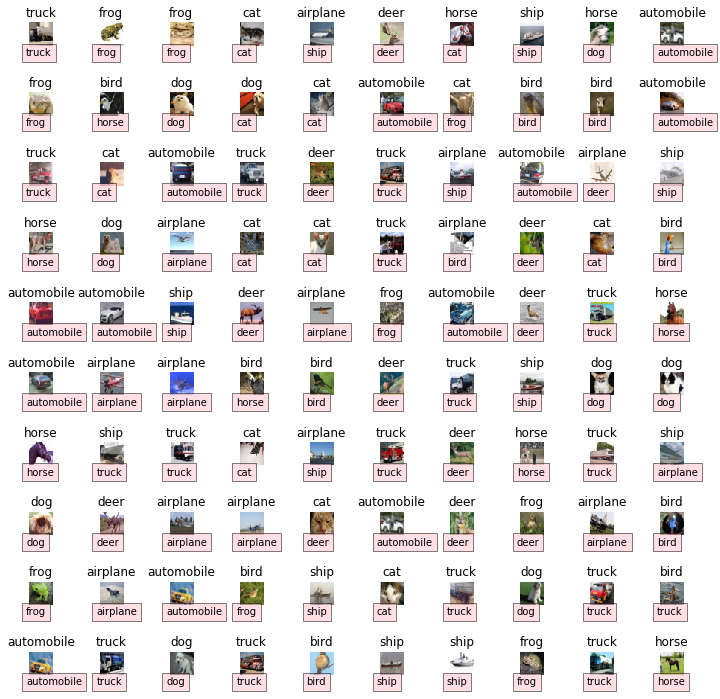

In [15]:
plot_random_100_images(X_test, y_test, prediction = y_test_predicted, prediction_provided = True )